In [1]:
#default_exp feature

# Feature Generation

<br>

### Imports

In [183]:
#exports
import numpy as np
import pandas as pd

from copy import copy
from evtdemand import data
from sklearn.decomposition import PCA

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
data_dir = '../data'
sites = ['staplegrove']
grid_points = None

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, weather_grid_points=grid_points, weather_sites=sites)

df_features.head()

,value,temperature_staplegrove_1,solar_irradiance_staplegrove_1,windspeed_north_staplegrove_1,windspeed_east_staplegrove_1,pressure_staplegrove_1,spec_humidity_staplegrove_1,temperature_staplegrove_2,solar_irradiance_staplegrove_2,windspeed_north_staplegrove_2,...,windspeed_north_staplegrove_4,windspeed_east_staplegrove_4,pressure_staplegrove_4,spec_humidity_staplegrove_4,temperature_staplegrove_5,solar_irradiance_staplegrove_5,windspeed_north_staplegrove_5,windspeed_east_staplegrove_5,pressure_staplegrove_5,spec_humidity_staplegrove_5
time,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00+00:00,1.101302,12.487909,0.0,4.610671,-1.894359,99478.780,0.008825,12.206659,0.0,3.715163,...,3.644850,-1.780101,99934.780,0.007918,12.917596,0.0,5.534499,-2.360667,99094.780,0.009035
2019-11-01 00:30:00+00:00,1.084653,12.490152,0.0,4.701822,-2.196463,99377.225,0.008861,12.263589,0.0,4.011881,...,3.905435,-1.952079,99849.225,0.008069,12.970621,0.0,5.651041,-2.244071,99001.225,0.009086
2019-11-01 01:00:00+00:00,0.998729,12.492395,0.0,4.792974,-2.498568,99275.670,0.008896,12.320520,0.0,4.308599,...,4.166020,-2.124056,99763.670,0.008221,13.023645,0.0,5.767583,-2.127474,98907.670,0.009136
2019-11-01 01:30:00+00:00,0.914548,12.565637,0.0,4.765775,-2.378908,99180.225,0.008974,12.405481,0.0,4.476712,...,4.104642,-2.421145,99652.225,0.008300,13.108606,0.0,5.418119,-1.564211,98832.225,0.009195
2019-11-01 02:00:00+00:00,0.875550,12.638879,0.0,4.738576,-2.259248,99084.780,0.009051,12.490442,0.0,4.644826,...,4.043263,-2.718233,99540.780,0.008380,13.193567,0.0,5.068654,-1.000948,98756.780,0.009253


In [5]:
# need to think about what's needed to forecast demand and solar
# should accept the baseline features df and pass back a new df to be joined (rather than directly adding)

<br>

### Temporal Features

In [71]:
#exports
def dt_rng_to_SPs(
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    freq: str='30T',
    tz: str='Europe/London'
):
    dt_rng = pd.date_range(start_date, end_date, freq=freq, tz=tz)

    SPs = list((2*(dt_rng.hour + dt_rng.minute/60) + 1).astype(int))
    dt_strs = list(dt_rng.strftime('%Y-%m-%d'))

    df_dates_SPs = pd.DataFrame({'date':dt_strs, 'SP':SPs}, index=dt_rng).astype(str)

    # Accounting for clock changes
    clock_change_dt_idxs_dir = pd.Series(dt_rng).apply(lambda dt: dt.utcoffset().total_seconds()).diff().replace(0, np.nan).dropna()

    for dt_idx, dir_ in clock_change_dt_idxs_dir.items():
        dt = dt_rng[dt_idx].date()
        SPs = (1 + 2*(dt_rng[dt_rng.date==dt] - pd.to_datetime(dt).tz_localize('Europe/London')).total_seconds()/(60*60)).astype(int)

        df_dates_SPs.loc[df_dates_SPs.index.date==dt, 'SP'] = SPs

    return df_dates_SPs

def create_temporal_features(df_features: pd.DataFrame):
    df_dates_SPs = dt_rng_to_SPs(
        df_features.index.min().strftime('%Y-%m-%d %H:%M'),
        df_features.index.max().strftime('%Y-%m-%d %H:%M')
    )
    
    df_dates_SPs.index = df_dates_SPs.index.tz_convert('UTC')
    
    df_temporal = pd.DataFrame({
        # 'SP': df_dates_SPs['SP'].values,
        'hour': df_features.index.hour + df_features.index.minute/60,
        'local_hour': df_features.index.tz_convert('Europe/London').hour + df_features.index.tz_convert('Europe/London').minute/60,
        'weekday': df_features.index.dayofweek,
        'weekend': df_features.index.dayofweek.isin([5, 6]),
        'doy': df_features.index.dayofyear,
        'month': df_features.index.month
    }, index=df_features.index)
    
    return df_temporal

In [72]:
df_temporal = create_temporal_features(df_features)

df_temporal.head()

,hour,local_hour,weekday,weekend,doy,month
time,,,,,,
2019-11-01 00:00:00+00:00,0.0,0.0,4,False,305,11
2019-11-01 00:30:00+00:00,0.5,0.5,4,False,305,11
2019-11-01 01:00:00+00:00,1.0,1.0,4,False,305,11
2019-11-01 01:30:00+00:00,1.5,1.5,4,False,305,11
2019-11-01 02:00:00+00:00,2.0,2.0,4,False,305,11


<br>

### Wind Vectors to Speed and Direction

In [205]:
#exports
def create_dir_speed_features(df_features: pd.DataFrame, site_gridpoint: str='staplegrove_1'):
    s_U, s_V = df_features[f'windspeed_east_{site_gridpoint}'], df_features[f'windspeed_north_{site_gridpoint}']
    
    df_speed_dir = pd.DataFrame({
        'direction': np.mod(180 + np.rad2deg(np.arctan2(s_U, s_V)), 360),
        'speed': np.sqrt(s_U**2 + s_V**2)
    })

    return df_speed_dir

def add_col_suffix(df, col_suffix: str='', col_prefix: str=''):
    df.columns = [f'{col_prefix}_{col}_{col_suffix}'.strip('_') for col in df.columns]

    return df

def isfloat(value):     
    try:
        float(value)
        return True
    except ValueError:
        return False
    
get_grid_points = lambda df_features, site: sorted(list(set([int(col.split(f'{site}_')[-1]) for col in list(df_features.columns[df_features.columns.str.contains(site)]) if isfloat(col.split(f'{site}_')[-1])])))

def iterate_feature_gen_over_site_gridpoints(
    df_features: pd.DataFrame,
    feature_gen_function: type(lambda x: x),
    sites: list=['staplegrove'],
    grid_points: type(None)=None,
    **kwargs
):
    """Accepts a function that can be passed `df_features` and `site_gridpoint`"""
    
    grid_points_original = copy(grid_points)
    combined_dfs = []
    
    for site in sites:
        if grid_points_original is None:
            grid_points = get_grid_points(df_features, site)
            
        combined_dfs += [
            feature_gen_function(df_features, f'{site}_{grid_point}', **kwargs).pipe(add_col_suffix, f'{site}_{grid_point}')
            for grid_point 
            in grid_points
        ]
        
    df = pd.concat(combined_dfs, axis=1)
            
    return df

<AxesSubplot:xlabel='speed_staplegrove_1', ylabel='Count'>

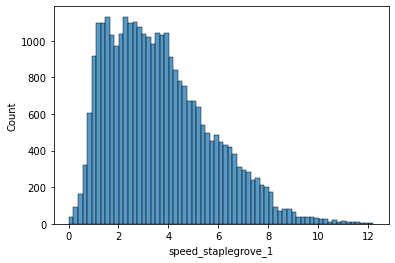

In [172]:
df_speed_dir = iterate_feature_gen_over_site_gridpoints(df_features, create_dir_speed_features, sites, grid_points)

sns.histplot(df_speed_dir['speed_staplegrove_1'])

<br>

### Heating/Cooling Degree Hour

In [75]:
#exports
def calc_hcdh_factor(
    t: float,
    hbt: float=10,
    cbt: float=20, 
    beta_0: float=0, 
    beta_1: float=1, 
    beta_2: float=2
):
    if isinstance(t, pd.Series):
        hdh = (hbt-t).to_frame().assign(ref=0).max(axis=1)
        cdh = (t-cbt).to_frame().assign(ref=0).max(axis=1)
        
    else:
        hdh = max(0, hbt-t)
        cdh = max(0, t-cbt)
    
    hcdh_factor = beta_0 + beta_1*hdh + beta_2*cdh
    
    return hcdh_factor

def create_hcdh_features(df_features: pd.DataFrame, site_gridpoint: str='staplegrove_1'):
    df_hcdh_factor = calc_hcdh_factor(df_features[f'temperature_{site_gridpoint}']).to_frame()
    df_hcdh_factor = df_hcdh_factor.rename(columns={0: f'hcdh'})
    
    return df_hcdh_factor

<AxesSubplot:xlabel='time'>

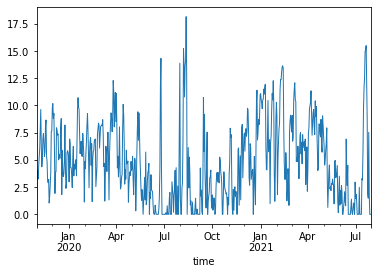

In [76]:
df_hcdh_factor = iterate_feature_gen_over_site_gridpoints(df_features, create_hcdh_features, sites, grid_points)

df_hcdh_factor['hcdh_staplegrove_1'].resample('d').max().plot(linewidth=1)

In [207]:
#exports
def create_feature_stats(
    df_features: pd.DataFrame,
    cols: list=['value'],
    method_1: str='rolling',
    method_2: str='mean',
    method_1_kwargs: dict={'window': 2},
    method_2_kwargs: dict={},
    col_names: list=[]
):
    if isinstance(cols, str):
        cols = [cols]
        
    if method_2 is None:
        df_feature_stats = getattr(df_features[cols], method_1)(**method_1_kwargs)
        method_2_str = ''
    else:
        df_feature_stats = getattr(getattr(df_features[cols], method_1)(**method_1_kwargs), method_2)(**method_2_kwargs)
        method_2_str = method_2 + '__' + '_'.join([f'{k}_{v}' for k, v in method_2_kwargs.items()])
        
    method_1_str = method_1 + '__' + '_'.join([f'{k}_{v}' for k, v in method_1_kwargs.items()])
    col_suffix = (method_1_str + '__' + method_2_str).strip('_')

    if isinstance(df_feature_stats, pd.Series):
        df_feature_stats = df_feature_stats.to_frame()
    else:
        df_feature_stats = df_feature_stats.pipe(add_col_suffix, '__' + col_suffix)
        
    if len(col_names) > 0:
        assert len(col_names)==len(df_feature_stats.columns)
        df_feature_stats.columns = col_names
    
    return df_feature_stats

def create_combined_feature_stats(
    df_features: pd.DataFrame,
    feature_stat_params: list
):
    df = pd.concat([
        create_feature_stats(df_features, **feature_stat_param) 
        for feature_stat_param
        in feature_stat_params
    ], axis=1)
    
    return df

def create_demand_stat_features(df_features: pd.DataFrame):
    feature_stat_params = [
        {
            'cols': ['value'],
            'method_1': 'ewm',
            'method_2': 'std',
            'method_1_kwargs': {'alpha': 0.9},
            'method_2_kwargs': {}
        }, 
        {
            'cols': ['value'],
            'method_1': 'ewm',
            'method_2': 'mean',
            'method_1_kwargs': {'alpha': 0.9},
            'method_2_kwargs': {}
        }, 
        {
            'cols': ['value'],
            'method_1': 'ewm',
            'method_2': 'mean',
            'method_1_kwargs': {'alpha': 0.01},
            'method_2_kwargs': {}
        }, 
        {
            'cols': ['value'],
            'method_1': 'rolling',
            'method_2': 'max',
            'method_1_kwargs': {'window': 12},
            'method_2_kwargs': {}
        }, 
        {
            'cols': ['value'],
            'method_1': 'rolling',
            'method_2': 'min',
            'method_1_kwargs': {'window': 24},
            'method_2_kwargs': {}
        }
    ]

    df_combined_feature_stats = create_combined_feature_stats(df_features, feature_stat_params)

    return df_combined_feature_stats

In [208]:
df_combined_feature_stats = create_demand_stat_features(df_features)

df_combined_feature_stats.head()

,value___ewm__alpha_0.9__std,value___ewm__alpha_0.9__mean,value___ewm__alpha_0.01__mean,value___rolling__window_12__max,value___rolling__window_24__min
time,,,,,
2019-12-08 00:00:00+00:00,NaN,1.307121,1.307121,NaN,NaN
2019-12-08 00:30:00+00:00,0.013337,1.289975,1.297643,NaN,NaN
2019-12-08 01:00:00+00:00,0.054701,1.220155,1.268968,NaN,NaN
2019-12-08 01:30:00+00:00,0.078864,1.121701,1.228821,NaN,NaN
2019-12-08 02:00:00+00:00,0.043421,1.076222,1.196654,NaN,NaN


In [151]:
#exports
def create_solar_features(
    df_features: pd.DataFrame,
    sites: list=['staplegrove'],
    grid_points: type(None)=None,
):
    grid_points_original = copy(grid_points)
    feature_stats_dfs = []
    
    for site in sites:
        if grid_points_original is None:
            grid_points = get_grid_points(df_features, site)            
            
        feature_stat_params_1 = [
            {
                'cols': [f'solar_irradiance_{site}_{grid_point}' for grid_point in grid_points],
                'method_1': 'mean',
                'method_2': None,
                'method_1_kwargs': {'axis': 1},
                'method_2_kwargs': {},
                'col_names': [f'solar_irradiance_{site}_mean']
            },
            {
                'cols': [f'solar_irradiance_{site}_{grid_point}' for grid_point in grid_points],
                'method_1': 'max',
                'method_2': None,
                'method_1_kwargs': {'axis': 1},
                'method_2_kwargs': {},
                'col_names': [f'solar_irradiance_{site}_max']
            },
            {
                'cols': [f'solar_irradiance_{site}_{grid_point}' for grid_point in grid_points],
                'method_1': 'min',
                'method_2': None,
                'method_1_kwargs': {'axis': 1},
                'method_2_kwargs': {},
                'col_names': [f'solar_irradiance_{site}_min']
            },
        ]
            
        feature_stat_params_2 = [
            {
                'cols': [f'solar_irradiance_{site}_max', f'solar_irradiance_{site}_min'],
                'method_1': 'diff',
                'method_2': None,
                'method_1_kwargs': {},
                'method_2_kwargs': {}
            },
            {
                'cols': [f'solar_irradiance_{site}_max', f'solar_irradiance_{site}_min'],
                'method_1': 'ewm',
                'method_2': 'mean',
                'method_1_kwargs': {'alpha': 0.9},
                'method_2_kwargs': {}
            }
        ]
        

        df_combined_site_feature_stats_1 = create_combined_feature_stats(df_features, feature_stat_params_1)
        df_combined_site_feature_stats_2 = create_combined_feature_stats(df_combined_site_feature_stats_1, feature_stat_params_2)
        
        feature_stats_dfs += [pd.concat([df_combined_site_feature_stats_1, df_combined_site_feature_stats_2], axis=1)]
        
    df_combined_feature_stats = pd.concat(feature_stats_dfs, axis=1)

    return df_combined_feature_stats

In [152]:
df_combined_feature_stats = create_solar_features(df_features)

df_combined_feature_stats.replace(0, np.nan).dropna().head()

,solar_irradiance_staplegrove_mean,solar_irradiance_staplegrove_max,solar_irradiance_staplegrove_min,solar_irradiance_staplegrove_max___diff,solar_irradiance_staplegrove_min___diff,solar_irradiance_staplegrove_max___ewm__alpha_0.9__mean,solar_irradiance_staplegrove_min___ewm__alpha_0.9__mean
time,,,,,,,
2019-11-01 06:30:00+00:00,1.945215,2.470703,1.259277,2.470703,1.259277,2.223633,1.133350
2019-11-01 07:00:00+00:00,3.890430,4.941406,2.518555,2.470703,1.259277,4.669629,2.380034
2019-11-01 07:30:00+00:00,23.399121,30.832031,14.382813,25.890625,11.864258,28.215791,13.182535
2019-11-01 08:00:00+00:00,42.907813,56.937500,25.554688,26.105469,11.171875,54.065329,24.317473
2019-11-01 08:30:00+00:00,73.760156,89.875000,52.964844,32.937500,27.410156,86.294033,50.100107


In [12]:
#exports
def create_prev_month_stats_df(df_features: pd.DataFrame, df_target: pd.DataFrame):
    s_avg_to_max = df_target['value_max'] - df_features['value']
    s_avg_to_min = df_target['value_min'] - df_features['value']

    df_prev_month_stats = pd.DataFrame({
        'prev_month_max_avg': s_avg_to_max.resample('MS').mean().shift().reindex(s_avg_to_max.index).ffill().dropna(),
        'prev_month_max_max': s_avg_to_max.resample('MS').max().shift().reindex(s_avg_to_max.index).ffill().dropna(),
        'prev_month_min_avg': s_avg_to_min.resample('MS').mean().shift().reindex(s_avg_to_min.index).ffill().dropna(),
        'prev_month_min_min': s_avg_to_min.resample('MS').min().shift().reindex(s_avg_to_min.index).ffill().dropna()
    })
    
    return df_prev_month_stats

In [13]:
df_prev_month_stats = create_prev_month_stats_df(df_features, df_target)

df_prev_month_stats.head()

,prev_month_max_avg,prev_month_max_max,prev_month_min_avg,prev_month_min_min
time,,,,
2019-12-01 00:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 00:30:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 01:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 01:30:00+00:00,0.10239,1.101552,-0.106499,-1.39748
2019-12-01 02:00:00+00:00,0.10239,1.101552,-0.106499,-1.39748


In [211]:
#exports
def create_lagged_df(
    df_features: pd.DataFrame,
    feature_lags: dict={'value': [1]}
):
    lagged_feature_dfs = []
    
    for feature, lags in feature_lags.items():
        lagged_feature_dfs += [pd.DataFrame({
            f'{feature}_lag_{lag}': df_features[feature].shift(lag)
            for lag 
            in lags
        })]
        
    df_lagged_features = pd.concat(lagged_feature_dfs, axis=1)
    
    return df_lagged_features

In [212]:
create_lagged_df(df_features).head()

,value_lag_1
time,
2019-12-08 00:00:00+00:00,NaN
2019-12-08 00:30:00+00:00,1.307121
2019-12-08 01:00:00+00:00,1.288260
2019-12-08 01:30:00+00:00,1.212475
2019-12-08 02:00:00+00:00,1.110773


In [192]:
#exports
def creat_demand_ts_pcs(
    df_features: pd.DataFrame,
    n_features: int=7*48
):
    df_trajectory_mat = df_features['value'].to_frame()

    for lag in range(1, n_features+1):
        df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)

    df_trajectory_mat = df_trajectory_mat.dropna()

    pca = PCA(n_components = 20)
    pca.fit(df_trajectory_mat)

    PCs = pca.fit_transform(df_trajectory_mat)
    df_PCs = pd.DataFrame(data=PCs, columns = ['demand_pc'+str(i+1) for i in range(pca.n_components)], index=df_trajectory_mat.index)

    return df_PCs

In [193]:
df_PCs = creat_demand_ts_pcs(df_features)

df_PCs.head()

C:\Users\Ayrto\AppData\Local\Temp/ipykernel_27412/3046020316.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


,demand_pc1,demand_pc2,demand_pc3,demand_pc4,demand_pc5,demand_pc6,demand_pc7,demand_pc8,demand_pc9,demand_pc10,demand_pc11,demand_pc12,demand_pc13,demand_pc14,demand_pc15,demand_pc16,demand_pc17,demand_pc18,demand_pc19,demand_pc20
time,,,,,,,,,,,,,,,,,,,,
2019-11-08 00:00:00+00:00,-4.939649,-2.950374,-4.138315,-4.301327,-0.324152,-0.070265,-0.441964,0.894779,1.758962,-0.066493,-0.901136,0.334401,0.497112,0.383993,0.028978,-0.119041,-0.186173,0.813461,-0.484009,0.364850
2019-11-08 00:30:00+00:00,-4.941106,-2.390805,-4.490844,-4.229933,0.798526,-0.000574,-0.456664,0.173878,2.040561,-0.168714,-0.724379,0.386774,0.496976,0.329999,-0.006823,-0.148666,-0.227917,0.453346,-0.932980,0.439374
2019-11-08 01:00:00+00:00,-4.941298,-1.789028,-4.767232,-3.872316,1.865242,0.071481,-0.482363,-0.596087,2.013897,-0.244541,-0.526474,0.438872,0.490548,0.275439,-0.042604,-0.185350,-0.274657,-0.071744,-1.134096,0.506742
2019-11-08 01:30:00+00:00,-4.942003,-1.157703,-4.963156,-3.250464,2.802695,0.133524,-0.519792,-1.295511,1.684373,-0.293012,-0.329931,0.493477,0.476432,0.222677,-0.079092,-0.222982,-0.328293,-0.619356,-1.035080,0.564436
2019-11-08 02:00:00+00:00,-4.944487,-0.509227,-5.075394,-2.405118,3.546765,0.180466,-0.567232,-1.817607,1.102763,-0.316576,-0.161389,0.545506,0.453357,0.172801,-0.116612,-0.256563,-0.387581,-1.042097,-0.662884,0.611183


In [196]:
#exports
def create_rate_of_change_features(
    df_features: pd.DataFrame,
    features: dict={
        'value': 3
    }
):
    df_roc = pd.DataFrame(index=df_features.index)
    
    for feature, order in features.items():
        for derivative  in range(order):
            derivative  += 1
            
            if derivative == 1:
                df_roc[f'{feature}_diff_{derivative}'] = df_features[feature].diff()
            else:
                df_roc[f'{feature}_diff_{derivative}'] = df_roc[f'{feature}_diff_{derivative-1}'].diff()
    
    return df_roc

In [197]:
df_roc = create_rate_of_change_features(df_features)

df_roc.head()

,value_diff_1,value_diff_2,value_diff_3
time,,,
2019-12-08 00:00:00+00:00,NaN,NaN,NaN
2019-12-08 00:30:00+00:00,-0.018861,NaN,NaN
2019-12-08 01:00:00+00:00,-0.075785,-0.056924,NaN
2019-12-08 01:30:00+00:00,-0.101702,-0.025917,0.031007
2019-12-08 02:00:00+00:00,-0.039604,0.062098,0.088015


In [233]:
#exports
def create_additional_features(
    df_features: pd.DataFrame, 
    df_target: pd.DataFrame=None,
    features: list=['temporal', 'dir_speed', 'hcdh', 'prev_month_stats', 'lagged', 'solar', 'demand', 'ts_pcs', 'roc'],
    sites: list=['staplegrove'],
    grid_points: type(None)=[1],
    feature_lags: dict={
        'value': [1, 2, 3, 4, 5, 6, 48, 96, 336],
        'solar_irradiance_staplegrove_1': [1, 2],
        'temperature_staplegrove_1': [1, 2],
    },
    roc_features: dict={
        'value': 3
    }
):
    if 'solar' in features:
        df_solar = create_solar_features(df_features, sites=sites, grid_points=grid_points)
        df_features = df_features.merge(df_solar, left_index=True, right_index=True)
    
    if 'demand' in features:
        df_features = df_features.merge(create_demand_stat_features(df_features), left_index=True, right_index=True)
        
    if 'temporal' in features:
        df_features = df_features.merge(create_temporal_features(df_features), left_index=True, right_index=True)
    
    if 'dir_speed' in features:
        df_dir_speed = iterate_feature_gen_over_site_gridpoints(df_features, create_dir_speed_features, sites, grid_points)
        df_features = df_features.merge(df_dir_speed, left_index=True, right_index=True)
    
    if 'hcdh' in features:
        df_hcdh = iterate_feature_gen_over_site_gridpoints(df_features, create_hcdh_features, sites, grid_points)
        df_features = df_features.merge(df_hcdh, left_index=True, right_index=True)
    
    if 'ts_pcs' in features:
        df_features = df_features.merge(creat_demand_ts_pcs(df_features), left_index=True, right_index=True)
    
    if 'prev_month_stats' in features:
        assert df_target is not None
        df_features = df_features.merge(create_prev_month_stats_df(df_features, df_target), left_index=True, right_index=True)
    
    if 'lagged' in features:
        df_features = df_features.merge(create_lagged_df(df_features, feature_lags), left_index=True, right_index=True)
    
    if 'roc' in features:
        df_features = df_features.merge(create_rate_of_change_features(df_features, roc_features), left_index=True, right_index=True)
        
    df_features = df_features.dropna()
    
    return df_features

In [230]:
sites = ['staplegrove', 'mousehole']
grid_points = None

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, weather_grid_points=grid_points, weather_sites=sites)
df_features = create_additional_features(df_features, df_target)

df_features.head()

C:\Users\Ayrto\AppData\Local\Temp/ipykernel_27412/3046020316.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


,value,temperature_mousehole_1,solar_irradiance_mousehole_1,windspeed_north_mousehole_1,windspeed_east_mousehole_1,pressure_mousehole_1,spec_humidity_mousehole_1,temperature_mousehole_2,solar_irradiance_mousehole_2,windspeed_north_mousehole_2,...,temperature_staplegrove_2_lag_2,temperature_staplegrove_3_lag_1,temperature_staplegrove_3_lag_2,temperature_staplegrove_4_lag_1,temperature_staplegrove_4_lag_2,temperature_staplegrove_5_lag_1,temperature_staplegrove_5_lag_2,value_diff_1,value_diff_2,value_diff_3
time,,,,,,,,,,,,,,,,,,,,,
2019-12-08 00:00:00+00:00,1.307121,12.767847,0.0,4.699928,10.067046,100461.4450,0.008782,12.369409,0.0,7.102272,...,10.030847,9.819269,9.448816,9.149347,8.816003,10.442316,9.995691,0.304933,0.279638,0.287056
2019-12-08 00:30:00+00:00,1.288260,12.788416,0.0,2.895878,10.391112,100476.8525,0.008647,12.563806,0.0,5.074588,...,10.219659,10.189722,9.819269,9.482690,9.149347,10.888940,10.442316,-0.018861,-0.323794,-0.603432
2019-12-08 01:00:00+00:00,1.212475,12.808984,0.0,1.091827,10.715179,100492.2600,0.008512,12.758203,0.0,3.046905,...,10.408472,10.667322,10.189722,10.085291,9.482690,11.208337,10.888940,-0.075785,-0.056924,0.266870
2019-12-08 01:30:00+00:00,1.110773,12.722681,0.0,-0.396153,10.781645,100529.4300,0.008058,12.750024,0.0,1.242214,...,10.608728,11.144922,10.667322,10.687891,10.085291,11.527734,11.208337,-0.101702,-0.025917,0.031007
2019-12-08 02:00:00+00:00,1.071169,12.636377,0.0,-1.884132,10.848112,100566.6000,0.007604,12.741846,0.0,-0.562477,...,10.808984,11.398462,11.144922,11.042993,10.687891,11.666040,11.527734,-0.039604,0.062098,0.088015


<br>

### Feature Processing

In [203]:
#exports
def process_features(
    df_features: pd.DataFrame,
    cols_subset = ['value', 'temperature_staplegrove_1', 'solar_irradiance_staplegrove_1', 'windspeed_north_staplegrove_1',
                   'windspeed_east_staplegrove_1', 'pressure_staplegrove_1', 'spec_humidity_staplegrove_1', 'hour', 'doy', 
                   'weekend', 'direction_staplegrove_1', 'speed_staplegrove_1', 'hcdh_staplegrove_1'],
):
    if cols_subset is None:
        return df_features
    
    df_features_processed = df_features.copy()
    
    common_cols_subset = df_features_processed.columns.intersection(pd.Index(cols_subset))
    df_features_processed = df_features_processed[common_cols_subset]
    
    return df_features_processed

In [175]:
process_features(df_features).head()

,value,temperature_staplegrove_1,solar_irradiance_staplegrove_1,windspeed_north_staplegrove_1,windspeed_east_staplegrove_1,pressure_staplegrove_1,spec_humidity_staplegrove_1,hour,weekend,doy,direction_staplegrove_1,speed_staplegrove_1,hcdh_staplegrove_1
time,,,,,,,,,,,,,
2019-12-01 00:30:00+00:00,1.341012,2.001352,0.0,-2.689359,-3.647770,100554.055,0.004244,0.5,True,335,53.600092,4.531984,7.998648
2019-12-01 01:00:00+00:00,1.271278,1.983270,0.0,-2.820953,-3.577589,100556.620,0.004221,1.0,True,335,51.743984,4.555976,8.016730
2019-12-01 01:30:00+00:00,1.190816,1.825113,0.0,-3.004172,-3.411294,100563.500,0.004193,1.5,True,335,48.631090,4.545544,8.174887
2019-12-01 02:00:00+00:00,1.181899,1.666956,0.0,-3.187390,-3.244998,100570.380,0.004165,2.0,True,335,45.513120,4.548568,8.333044
2019-12-01 02:30:00+00:00,1.126943,1.610712,0.0,-3.290207,-3.216386,100571.147,0.004142,2.5,True,335,44.349972,4.601152,8.389288


In [20]:
# convert the wind vectors into speed and direction
# add in the settlement period (DST adjusted)
# add in a seasonal factor
# add in the day-of-week (or at least weekday v weekend)
# would normally also need actual time for the solar side but that's less important when we have irradicance data
# add a heating/cooling degree hour feature, use 10degC and 20degC for the base temperatures

# params for the dist of last month's spread between avg and min/max
# add in long-term trend (bias)
# should introduce some lagged variables
# should try and incorporate a volatility factor
# should look into technical indicators (normally for mkts but some could be useful for demand behaviour, should at least try ROC and EMA) - https://www.mdpi.com/2076-3417/10/1/255

In [234]:
#hide
from nbdev.export import notebook2script

notebook2script()

Converted 01-data-processing.ipynb.
Converted 02-spatial-analysis.ipynb.
Converted 03a-feature-generation.ipynb.
Converted 03b-eda.ipynb.
Converted 04-model-suite.ipynb.
Converted 05-custom-models.ipynb.
Converted 06-submission.ipynb.
Converted 07-experiments.ipynb.
Converted 08-testing.ipynb.
